In [1]:

from pyspark.mllib.recommendation import ALS, Rating
from pyspark.rdd import RDD
from pyspark.sql import SparkSession, Row
import random
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("MovieLensReader") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [5]:

rawUD = sc.textFile("u.data")
rawRatings = rawUD.map(lambda line: line.split("\t")[:3])
ratingsRDD = rawRatings.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, rand
import random

# Convert RDD to DataFrame
df = ratingsRDD.toDF()

# Step 1: Filter users with ≥ 5 ratings
user_counts = df.groupBy("user").agg(F.count("*").alias("count"))
eligible_users = user_counts.filter(col("count") >= 5).select("user").rdd.flatMap(lambda x: x).collect()

# Step 2: Sample 20% OOD users
ood_users = set(random.sample(eligible_users, int(0.2 * len(eligible_users))))
id_users = set(eligible_users) - ood_users

# Step 3: ID users data for training
train_df = df.filter(col("user").isin(list(id_users)))

# Step 4: OOD users data split into 80/20
ood_df = df.filter(col("user").isin(list(ood_users)))
ood_df = ood_df.withColumn("rand", rand())

ood_train_df = ood_df.filter(col("rand") <= 0.8)
ood_test_df = ood_df.filter(col("rand") > 0.8)

# Step 5: Final full train and test datasets (still Spark DataFrames)
full_train_df = train_df.select("user", "product").union(ood_train_df.select("user", "product"))
final_test_df = ood_test_df.select("user", "product", "rating")

# Step 6: Convert to Pandas for LightGCN processing
train_pd = full_train_df.toPandas()
test_pd = final_test_df.toPandas()


In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit encoders on train set
train_pd['user_enc'] = user_encoder.fit_transform(train_pd['user'])
train_pd['item_enc'] = item_encoder.fit_transform(train_pd['product'])

# Filter test users/items to those seen during training
test_pd = test_pd[
    test_pd['user'].isin(user_encoder.classes_) &
    test_pd['product'].isin(item_encoder.classes_)
].copy()

# Transform test set
test_pd['user_enc'] = user_encoder.transform(test_pd['user'])
test_pd['item_enc'] = item_encoder.transform(test_pd['product'])

# Step 2: Tensor Conversion for LightGCN 
user_tensor = torch.tensor(train_pd["user_enc"].values, dtype=torch.long)
item_tensor = torch.tensor(train_pd["item_enc"].values, dtype=torch.long)

# Get total user/item counts for model
num_users_enc = len(user_encoder.classes_)
num_items_enc = len(item_encoder.classes_)

# Create symmetric edge_index for LightGCN
edge_u = user_tensor
edge_v = item_tensor + num_users_enc  # offset items
edge_index = torch.stack([
    torch.cat([edge_u, edge_v]),
    torch.cat([edge_v, edge_u])
])

# Training pairs for BPR loss
train_pairs = torch.stack([user_tensor, item_tensor], dim=1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LightGCN Model
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, n_layers=3):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        self.n_layers = n_layers

    def forward(self, edge_index):
        emb = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        all_emb = [emb]

        for _ in range(self.n_layers):
            emb = self.propagate(edge_index, emb)
            all_emb.append(emb)

        emb = torch.stack(all_emb, dim=0).mean(0)
        return emb[:self.user_embedding.num_embeddings], emb[self.user_embedding.num_embeddings:]

    def propagate(self, edge_index, emb):
        row, col = edge_index
        deg = torch.bincount(row, minlength=emb.size(0))
        deg_inv_sqrt = deg.float().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        adj = torch.sparse_coo_tensor(edge_index, norm, (emb.size(0), emb.size(0)))
        return torch.sparse.mm(adj, emb)

    def predict(self, user_emb, item_emb, user_ids, item_ids):
        return (user_emb[user_ids] * item_emb[item_ids]).sum(dim=1)


In [9]:
def bpr_loss(pos_scores, neg_scores):
    return -torch.mean(F.logsigmoid(pos_scores - neg_scores))


In [10]:
def train_lightgcn(model, edge_index, user_item_pairs, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        user_emb, item_emb = model(edge_index)
        user_ids = user_item_pairs[:, 0]
        pos_items = user_item_pairs[:, 1]
        neg_items = torch.randint(0, item_emb.shape[0], pos_items.shape)

        pos_scores = model.predict(user_emb, item_emb, user_ids, pos_items)
        neg_scores = model.predict(user_emb, item_emb, user_ids, neg_items)
        loss = bpr_loss(pos_scores, neg_scores)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


In [11]:
model = LightGCN(num_users_enc, num_items_enc)
train_lightgcn(model, edge_index, train_pairs)


Epoch 1/10, Loss: 0.6931
Epoch 2/10, Loss: 0.6918
Epoch 3/10, Loss: 0.6887
Epoch 4/10, Loss: 0.6830
Epoch 5/10, Loss: 0.6747
Epoch 6/10, Loss: 0.6636
Epoch 7/10, Loss: 0.6503
Epoch 8/10, Loss: 0.6340
Epoch 9/10, Loss: 0.6156
Epoch 10/10, Loss: 0.5955


In [12]:
# Filter to only known users and items
test_pd = test_pd[
    test_pd['user'].isin(user_encoder.classes_) &
    test_pd['product'].isin(item_encoder.classes_)
].copy()

# Encode using previously trained encoders
test_pd['user_enc'] = user_encoder.transform(test_pd['user'])
test_pd['item_enc'] = item_encoder.transform(test_pd['product'])


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Switch model to eval mode
model.eval()
with torch.no_grad():
    # Get user and item embeddings
    user_emb, item_emb = model(edge_index)

    # Prepare tensors for evaluation
    test_user_ids = torch.tensor(test_pd["user_enc"].values, dtype=torch.long)
    test_item_ids = torch.tensor(test_pd["item_enc"].values, dtype=torch.long)

    # Predict ratings
    predictions = model.predict(user_emb, item_emb, test_user_ids, test_item_ids)

# Compute metrics
labels = test_pd["rating"].values
preds = predictions.numpy()

rmse = mean_squared_error(labels, preds)
mae = mean_absolute_error(labels, preds)

print(f"Evaluation Complete:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


Evaluation Complete:
RMSE: 4.7406
MAE:  1.7361


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import torch

def multi_track_evaluation(test_pd, model, edge_index, user_emb, item_emb, seed=42, ood_ratio=0.2):
 
    # Fix seed for reproducibility
    random.seed(seed)

    # Sample OOD users from users present in test set
    test_user_pool = list(test_pd["user"].unique())
    num_ood = max(1, int(len(test_user_pool) * ood_ratio))
    ood_users = set(random.sample(test_user_pool, num_ood))
    id_users = set(test_user_pool) - ood_users

    # Split test set
    test_pd["user_orig"] = test_pd["user"]
    id_test_pd = test_pd[test_pd["user_orig"].isin(id_users)]
    ood_test_pd = test_pd[test_pd["user_orig"].isin(ood_users)]

    # Define reusable metric function
    def evaluate(test_df):
        user_ids = torch.tensor(test_df["user_enc"].values, dtype=torch.long)
        item_ids = torch.tensor(test_df["item_enc"].values, dtype=torch.long)
        labels = test_df["rating"].values
        with torch.no_grad():
            preds = model.predict(user_emb, item_emb, user_ids, item_ids).numpy()
        return mean_squared_error(labels, preds), mean_absolute_error(labels, preds)

    # Run evaluations
    rmse_all, mae_all = evaluate(test_pd)
    rmse_id, mae_id = evaluate(id_test_pd)
    rmse_ood, mae_ood = evaluate(ood_test_pd)
    plt.bar(['ID', 'OOD'], [rmse_id, rmse_ood], color=['skyblue', 'salmon'])
    plt.ylabel("RMSE")
    plt.title("Model Robustness: In-Distribution vs Out-of-Distribution")
    plt.grid(True)
    plt.show()

    # Print results
    print("\n Multi-Track Evaluation Results (LightGCN)")
    print(f"1. Overall Test Set     RMSE: {rmse_all:.4f}, MAE: {mae_all:.4f}")
    print(f"2. In-Distribution (ID)  RMSE: {rmse_id:.4f}, MAE: {mae_id:.4f}")
    print(f"3. Out-of-Distribution   RMSE: {rmse_ood:.4f}, MAE: {mae_ood:.4f}")

    return {
        "overall": {"rmse": rmse_all, "mae": mae_all},
        "id": {"rmse": rmse_id, "mae": mae_id},
        "ood": {"rmse": rmse_ood, "mae": mae_ood}
    }


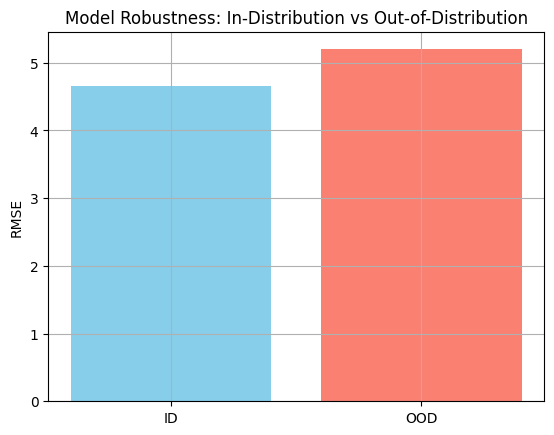


 Multi-Track Evaluation Results (LightGCN)
1. Overall Test Set     → RMSE: 4.7406, MAE: 1.7361
2. In-Distribution (ID) → RMSE: 4.6552, MAE: 1.7216
3. Out-of-Distribution  → RMSE: 5.1994, MAE: 1.8140


In [29]:
model.eval()
with torch.no_grad():
    user_emb, item_emb = model(edge_index)

results = multi_track_evaluation(test_pd, model, edge_index, user_emb, item_emb)


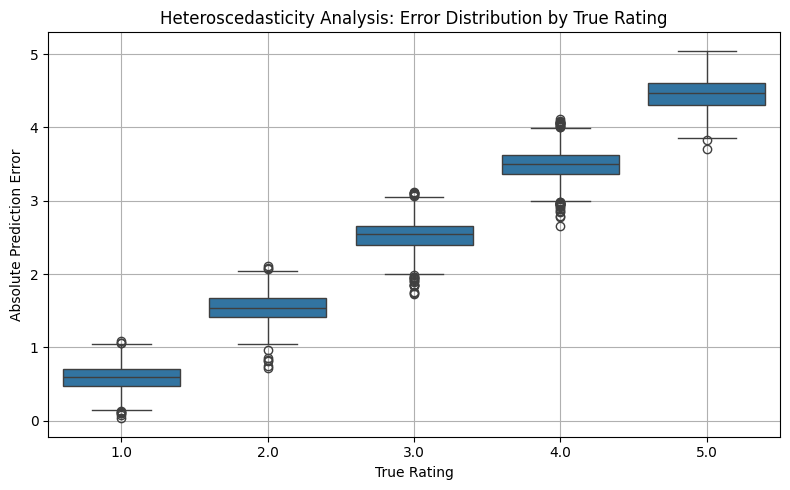

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add residuals to test set
test_pd["pred"] = predictions.numpy()
test_pd["error"] = abs(test_pd["rating"] - test_pd["pred"])

# Plot error distribution by true rating
plt.figure(figsize=(8, 5))
sns.boxplot(x="rating", y="error", data=test_pd)
plt.title("Heteroscedasticity Analysis: Error Distribution by True Rating")
plt.xlabel("True Rating")
plt.ylabel("Absolute Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
embedding_dims = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
train_rmse_values = []
test_rmse_values = []

for dim in embedding_dims:
    print(f"\nTraining LightGCN with embedding_dim={dim}")

    # Sample 30% training data
    train_small = train_pd.sample(frac=0.3, random_state=42).reset_index(drop=True)
    user_tensor = torch.tensor(user_encoder.transform(train_small["user"]), dtype=torch.long)
    item_tensor = torch.tensor(item_encoder.transform(train_small["product"]), dtype=torch.long)

    edge_u = user_tensor
    edge_v = item_tensor + num_users_enc
    edge_index = torch.stack([torch.cat([edge_u, edge_v]), torch.cat([edge_v, edge_u])])
    train_pairs = torch.stack([user_tensor, item_tensor], dim=1)

    # Train
    model = LightGCN(num_users_enc, num_items_enc, embedding_dim=dim)
    train_lightgcn(model, edge_index, train_pairs, epochs=10)

    with torch.no_grad():
        user_emb, item_emb = model(edge_index)

        # Train RMSE
        train_preds = model.predict(user_emb, item_emb, user_tensor, item_tensor).numpy()
        train_rmse = mean_squared_error(np.ones_like(train_preds), train_preds) ** 0.5
        train_rmse_values.append(train_rmse)

        # Test RMSE
        user_ids = torch.tensor(test_pd["user_enc"].values, dtype=torch.long)
        item_ids = torch.tensor(test_pd["item_enc"].values, dtype=torch.long)
        test_preds = model.predict(user_emb, item_emb, user_ids, item_ids).numpy()
        test_rmse = mean_squared_error(test_pd["rating"], test_preds) ** 0.5
        test_rmse_values.append(test_rmse)

    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")



Training LightGCN with embedding_dim=8
Epoch 1/10, Loss: 0.6931
Epoch 2/10, Loss: 0.6930
Epoch 3/10, Loss: 0.6925
Epoch 4/10, Loss: 0.6918
Epoch 5/10, Loss: 0.6907
Epoch 6/10, Loss: 0.6892
Epoch 7/10, Loss: 0.6873
Epoch 8/10, Loss: 0.6848
Epoch 9/10, Loss: 0.6820
Epoch 10/10, Loss: 0.6787
Train RMSE: 0.9303, Test RMSE: 3.6389

Training LightGCN with embedding_dim=16
Epoch 1/10, Loss: 0.6931
Epoch 2/10, Loss: 0.6928
Epoch 3/10, Loss: 0.6921
Epoch 4/10, Loss: 0.6907
Epoch 5/10, Loss: 0.6886
Epoch 6/10, Loss: 0.6858
Epoch 7/10, Loss: 0.6821
Epoch 8/10, Loss: 0.6777
Epoch 9/10, Loss: 0.6722
Epoch 10/10, Loss: 0.6662
Train RMSE: 0.8690, Test RMSE: 3.5851

Training LightGCN with embedding_dim=32
Epoch 1/10, Loss: 0.6930
Epoch 2/10, Loss: 0.6925
Epoch 3/10, Loss: 0.6912
Epoch 4/10, Loss: 0.6887
Epoch 5/10, Loss: 0.6851
Epoch 6/10, Loss: 0.6798
Epoch 7/10, Loss: 0.6732
Epoch 8/10, Loss: 0.6651
Epoch 9/10, Loss: 0.6556
Epoch 10/10, Loss: 0.6444
Train RMSE: 0.7592, Test RMSE: 3.4871

Training L

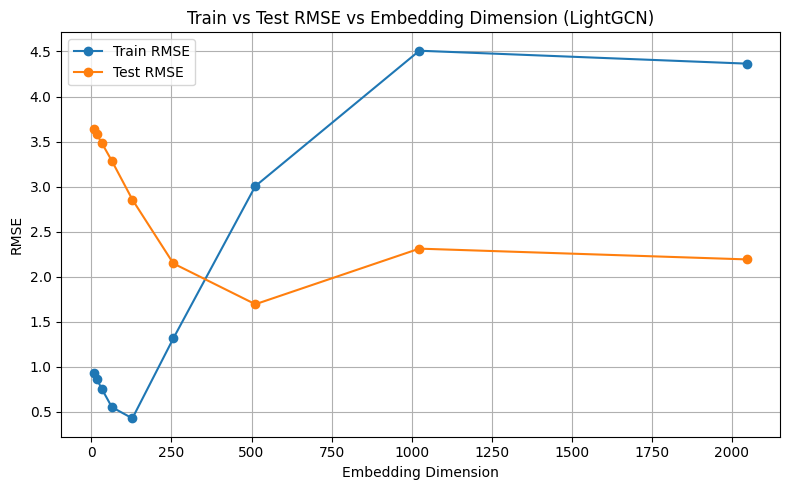

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(embedding_dims, train_rmse_values, marker='o', label="Train RMSE")
plt.plot(embedding_dims, test_rmse_values, marker='o', label="Test RMSE")
plt.title("Train vs Test RMSE vs Embedding Dimension (LightGCN)")
plt.xlabel("Embedding Dimension")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
from collections import defaultdict

def precision_recall_f1_at_k(model, user_emb, item_emb, test_df, K=10, threshold=4.0):
    """
    Computes Precision@K, Recall@K, and F1@K based on predicted top-K recommendations.
    """
    user_to_items = defaultdict(list)
    for row in test_df.itertuples():
        if row.rating >= threshold:
            user_to_items[row.user_enc].append(row.item_enc)

    users = list(user_to_items.keys())
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for user in users:
        gt_items = set(user_to_items[user])
        if not gt_items:
            continue

        # Predict scores for all items for this user
        scores = (user_emb[user] * item_emb).sum(dim=1).numpy()
        top_k_items = np.argsort(scores)[-K:][::-1]  # top-K highest scores

        pred_items = set(top_k_items)
        hits = gt_items & pred_items

        precision = len(hits) / K
        recall = len(hits) / len(gt_items)
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"Precision@{K}: {avg_precision:.4f}")
    print(f"Recall@{K}:    {avg_recall:.4f}")
    print(f"F1@{K}:        {avg_f1:.4f}")

    return avg_precision, avg_recall, avg_f1


In [33]:
model.eval()
with torch.no_grad():
    user_emb, item_emb = model(edge_index)

precision_at_10, recall_at_10 , f1 = precision_recall_f1_at_k(
    model, user_emb, item_emb, test_pd, K=10, threshold=4.0
)


Precision@10: 0.0785
Recall@10:    0.1073
F1@10:        0.0750
